# Random Numbers

Here we will see some of the uses of random numbers.  We will explore the transformation method.  We will also look at a simple application of Monte Carlo integration and apply it to calculating $\pi$.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

Functions for generating random numbers are contained in the `np.random` module.  Notice that it contains functions for many probability distributions and many utility functions for generating different types of random numbers.  In practice generating random sequences of floating point numbers, integers, and bytes requires care to insure the results are not biased.

In [ ]:
np.random?

The interface for generating random numbers has utility functions and compatibility functions.  We have mainly used the compatibility functions.  They are modeled after common function names from other languages.  The utility functions are more "pythonic" in design.  Though they do similar things, the way in which the compatibility and utility functions are called and the way they treat their arguments can be different.  You should always check the documenation before using a function!

Finally, there is ongoing work to modernize the interface.  This will provide a new way of more easily accessing and trying different random number generators. This work has progressed rapidly and recent versions of numpy have this new way of using random numbers. Really any new project should use these new functions. Even so, they are so new  and we will continue to use the old functions since so much old code (or if you are using older versions of numpy) will be using these old functions.

## Exponential Probability Distribution

The exponential probability distribution is useful in many contexts.  In fact, it is implemented as `np.random.exponential`.  This function allows $t$ to take any value from zero to infinity.  Suppose we want to restrict our choice to a finite range.  Here we will use the transformation method to derive the mapping from the uniform distribution on the unit interval to the exponential distribution on a finite interval.

Consider the probability density
$$ P(t) \,\mathrm{d}t = N \mathrm{e}^{-t/\tau} \,\mathrm{d}t, $$
where $N$ is a normalization and $\tau$ describes the scale of the distribution.  In the case of particle decays $\tau$ would represent the lifetime of the particle.  Suppose we wish to pick random numbers in the interval $t_1\le t< t_2$.

### Normalization

First we normalize the probability distribution.  This requires
$$ 1 = \int_{t_1}^{t_2} N \mathrm{e}^{-t/\tau} \,\mathrm{d}t = \tau N \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right).  $$
Solving for the normalization constant we find
$$ \frac{1}{N} = \tau\left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right). $$

### Mapping

Next we map from a uniformly distributed random variable, $u$, on the interval $[0,1)$ to the exponential distribution.  This mapping requires
$$ u = \int_{t_1}^{t} N \mathrm{e}^{-t'/\tau} \,\mathrm{d}t' = \tau N \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t/\tau} \right). $$
We can invert this to solve for $t$.  Doing so gives the desired mapping
$$ t = -\tau \ln\left[ \mathrm{e}^{-t_1/\tau} - u \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right) \right]. $$

### Testing the Mapping

To test the mapping consider the set of parameters $\tau=1.5$, $t_1=0.7$, $t_2=5$.  We will generate a large set of uniformly distributed random numbers and apply the mapping.  To verify that it has the correct distribution we create a histogram using `hist` and plot it along with the true probability distribution.  Note that the true probability distribution is normalized (we did this above to find $N$) thus we must also normalize the histogram.  This is accomplished using the `density` keyword argument to `hist`. (An older way of doing this was to use the `normed` keyword argument.  That is now deprecated and you will get a warning if you use it.)

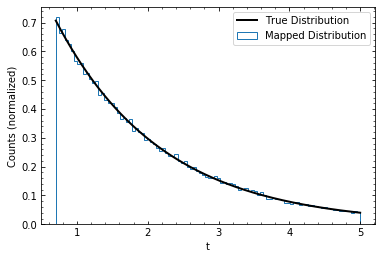

In [2]:
tau = 1.5
t1 = 0.7
t2 = 5.0

# Normalization
N = 1 / tau / (np.exp(-t1/tau) - np.exp(-t2/tau))

# Probability distribution
def P(t) :
    return N * np.exp(-t/tau)

# Generate uniformly distributed random numbers
n = 100000
u = np.random.random(n)

# Map them to the exponential distribution
t = -tau * np.log(np.exp(-t1/tau) - u*(np.exp(-t1/tau) - np.exp(-t2/tau)))

tfine = np.linspace(t1, t2, 1000)

# Plot the results
plt.plot(tfine, P(tfine), 'k-', lw=2, label='True Distribution')
plt.hist(t, bins=100, histtype='step', density=True, label='Mapped Distribution')
plt.xlabel('t')
plt.ylabel('Counts (normalized)')
plt.legend();

## Uniformly Sample the Disk

To uniformly sample the area of a disk we do **not** uniformly sample in $r$ and $\theta$.  To see this let us try uniformly sampling inside the unit circle.

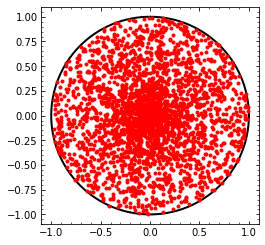

In [3]:
# For the edge of the circle:
theta_circle = np.linspace(0, 2*np.pi, 1000)
X = np.cos(theta_circle)
Y = np.sin(theta_circle)

N = 3000
r = np.random.random(size=N)
theta = 2*np.pi * np.random.random(size=N)
x = r*np.cos(theta)
y = r*np.sin(theta)

fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.plot(X, Y, 'k-', lw=2)
ax.plot(x, y, 'r.');

Notice that there are far more points near the center of the circle than there are near the edges.  This makes sense.  Consider two points separated by a small difference in $\theta$.  For $r$ small these two points would be very near each other.  On the other hand, for a larger $r$ they would be much further apart.  Clearly we should not uniformly sample in both $r$ and $\theta$, so, how should we sample?

Recall that the area element written in Cartesian coordinates is just $\mathrm{d}A = \mathrm{d}x\, \mathrm{d}y$.  However, in polar coordinates it is written as $\mathrm{d}A = r\mathrm{d}r\, \mathrm{d}\theta$.  This effects how we calculate probabilities.  For a uniform distribution in Cartesian coordinates the probability of finding $0\le x' < x$ and $0\le y' < y$ is given by
$$ P_{\mathrm{Cartesian}}(x,y) = \int_0^x \mathrm{d}x' \int_0^y \mathrm{d}y'. $$
Notice that $x$ and $y$ separate, the two integrals are independent of each other, so we can treat $x$ and $y$ as two independent uniformly distributed random variables.  This means uniformly sampling the square is easy, just pick $x$ and $y$ independently.

In polar coordinates things are different.  The probability of finding $0\le r'< r$ and $0\le\theta'<\theta$ is given by
$$ P_{\mathrm{polar}}(r,\theta) = \frac{1}{\pi} \int_0^r r'\,\mathrm{d}r' \int_0^{\theta} \mathrm{d}\theta'. $$
We see that again $r$ and $\theta$ are independent of each other.  We also see that the probability distribution does not depend on $\theta$ so we can treat $\theta$ as a uniformly distributed random number, but we *cannot do the same* for $r$.  Instead we see that
$$ p(r) \,\mathrm{d}r \propto r \,\mathrm{d}r. $$
As we saw in class, if $u$ is a uniformly distributed random number, then we can relate it to one that has a linear probability density by $r=\sqrt{u}$.  Thus we can remap the random numbers calculated above to uniformly sample the disk.

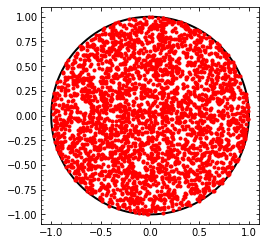

In [4]:
# We do NOT change the random numbers.  We reuse the ones we calculated
# above, but remap them.
R = np.sqrt(r)

x = R*np.cos(theta)
y = R*np.sin(theta)

fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.plot(X, Y, 'k-', lw=2)
ax.plot(x, y, 'r.');

Now we have uniformly sampled the circle!

## Calculating $\pi$ with Shotgun

How would you estimate $\pi$ if you only had a shotgun on hand?  Why you would have a shotgun but not some other basic device that could help you determine $\pi$ I do not know, but this question has been been answered as can be seen in an [ArXiv blog post](https://medium.com/the-physics-arxiv-blog/how-mathematicians-used-a-pump-action-shotgun-to-estimate-pi-c1eb776193ef).  In fact it is a standard problem using the rejection method for performing Monte Carlo integration.  (Actually, when applied to the case of using a shotgun it involves importance sampling, the details of which we did not discuss but builds on topics we have discussed.)

The idea is fairly simple.  Consider the unit circle.  We can enclose this inside a square with sides of length 2.  Mathematically we know the areas of the two objects,
$$ A_{\mathrm{square}} = 4 \quad\mathrm{and}\quad A_{\mathrm{circle}} = \pi. $$
Numerically, if we uniformly sample $N_{\mathrm{square}}$ points inside the square, something that is easy to do as discussed above, then some number of them will also fall inside the circle.  We can count this number and will call it $N_{\mathrm{circle}}$.  The ratio of the number of points that fall inside the circle to the total number of points will be nothing more than the ratio of the area of the circle to the area of the square.  In other words,
$$ \frac{N_{\mathrm{circle}}}{N_{\mathrm{square}}} = \frac{A_{\mathrm{circle}}}{A_{\mathrm{square}}} = \frac{\pi}{4}, $$
so
$$ \pi = 4 \frac{N_{\mathrm{circle}}}{N_{\mathrm{square}}}. $$
This we can easily calculate!

Consider an example with $N_{\mathrm{square}} = 100000$.

In [5]:
N = 100000
# pick x and y in interval (-1, 1)
x = 2*np.random.random(N) - 1
y = 2*np.random.random(N) - 1
# find those inside the unit circle
ind, = np.where(x**2 + y**2 <= 1)
# count them
Ncircle = len(ind)
# Estimate pi
pi_est = (4.0*Ncircle)/N
print(f"pi estimate : {pi_est} has fractional error {100*np.abs(1-pi_est/np.pi)}%")

pi estimate : 3.15 has fractional error 0.26761414789406857%


Using 100,000 points we see we get about 3 digits of accuracy.  To go beyond this we should find the accuracy as a function of the number of points sampled.  Further, since we are using random numbers we will not get the exact same answer each time so we will average over a few samples.

Here we write a function to do the hard work for us.  I have sped it up by not using two loops for the computations.  The calculations are much faster without using a double loop, that is, if you do not run out of RAM by trying to calculate too much at once!  So, be careful when running this, particularly for larger values of `N`!

In [6]:
def pi_MC(N, ntries) :
    """
    Monte Carlo estimate of pi using the rejection method.
    Random points are chosen inside a square with sides of length 2.
    The ratio of the number of points inside the unit circle centered at the middle
    of the circle to the total number of points generated is pi/4.
    N points are generated for each of ntries realizations.
    Returned is an array containing the estimate of pi for each realization.
    """
    # Generate all the realizations at once.  This is significantly
    # faster than using a loop!
    x = 2*np.random.random(size=(ntries,N)) - 1
    y = 2*np.random.random(size=(ntries,N)) - 1
    # find those inside the unit circle
    ind = (x**2 + y**2 <= 1)
    # Count them.
    # Here we use the fact the True=1 and False=0
    Ncircle = np.sum(ind, axis=-1)
    # Estimate pi
    return (4.0*Ncircle)/N

Narr = np.logspace(3, 6, 8).astype(int)
ntries = 100
pi_est = np.zeros((len(Narr), ntries))
# Here we do need to loop over each number of points
# we wish to generate.
for i in range(len(Narr)) :
    pi_est[i] = pi_MC(Narr[i], ntries)
pi_avg_err = np.mean(np.abs(pi_est-np.pi), axis=1)

Next we look at the average errors as a function of the number of points sampled.  The major downside with using Monte Carlo integration is that it converges very slowly.  It behaves like a random walk so the error is expected to decrease only as the square root of the number of samples.  We see this in the results.

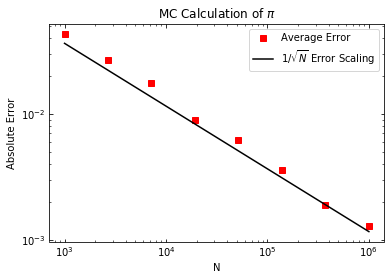

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(Narr, pi_avg_err, 'rs', label='Average Error')
A = np.sqrt(Narr[-2]) * pi_avg_err[-2]
n = np.logspace(3, 6, 100)
ax.loglog(n, A/np.sqrt(n), 'k-', label=r'$1/\sqrt{N}$ Error Scaling')
ax.legend(numpoints=1)
ax.set_xlabel('N')
ax.set_ylabel('Absolute Error')
ax.set_title(r'MC Calculation of $\pi$');

## Multiple Random Streams and Reproducibility

It was mentioned in class that pseudo-random numbers are preferable to cryptographically secure random numbers for scientific applications since a scientific result should be reproducible.  In the "old days" a random number generator took an integer as a seed.  Knowing this integer and the algorithm used for generating our pseudo-random numbers we could reproduce the sequence at some later time.  This can still be done using the `seed` function.  However, more modern random number generators, such as the Mersenne-Twister, have much more complicated state information and this complete state can be saved and restored.

Note that it is sadly quite rare to actually save the state information.  Typically we perform our calculations starting from an unknown state and do not worry about it.  Of course the results should *not depend* on the state of the random number generator, this is an important test of the results in general.  In practice I have only found the need to worry about this while debugging code.  If "something funny happens" it is quite useful to be able to repeat it as you try to find the source of the problem.

Related to this we may want or need multiple independent streams of random numbers.  By default the system creates a random number generator object for you when you load `numpy`.  When you ask for random numbers it uses this object.  If we want to have a separate or multiple independent streams of random numbers we can create our own objects.  This is particularly important in multi-threaded programs.  Creating a random number generator object is simple.

In [8]:
# Our own random number generator.
myran = np.random.RandomState()

We can look at its state, it is a bunch of information!

In [9]:
print(myran.get_state())

('MT19937', array([2147483648, 2014963721, 3715541476, 1206726753, 3525596306,
       2667202074, 4093242395,  719296419, 2473144207, 3431633978,
       1940000272, 1668993302, 2182446787, 3790083304,  595003765,
       1832586087,  407464527, 2259086454, 1809804685,  106544405,
        589818833,  742747109, 1680610446, 1942436603, 2661792385,
        206587680, 1332238618, 3417561503,  716414629,  853991974,
        806929370, 2208740794, 2415215539, 2516716690, 2613960927,
       1064658553, 3341144339, 1508922000, 1184097521,  867703108,
       2211988926, 1424197587, 2069880685, 3149569110, 1174947934,
        561370869, 3378705888, 3269995828, 2043040320, 3124211559,
       1147360433, 2212291856, 3962843202,  463012281, 1527075879,
        263672587, 1713805696, 2299718882, 3414449014,  653077313,
        726907077, 3204639810,  497827822, 2306851043, 1143316963,
       3797649227, 1473295938, 1363506633, 2631117669, 3863051169,
       1486321781, 3889129907, 2656240565, 4075814

We can now use `myran` as we would the general object `np.random`.  For example we can find 10 random integers between 0 and 4 (inclusive!).

In [10]:
print(myran.randint(0, 4+1, size=10))

[2 4 2 0 1 0 1 3 1 4]


Notice that this changes the state of the random number generator (the numbers in the array have changed).

In [11]:
print(myran.get_state())

('MT19937', array([2829245053, 1137941912, 4054402020, 3731650865, 2963858440,
       2959160853, 1620480691, 3102692797, 3556698630, 2082023522,
       3832110691, 1716021202,   27357777,  824098234, 1945421089,
       4123386631, 2831811426,  482155393, 3445598514,  825787090,
       1908216618, 2163387825, 2048345170, 1169200706, 2640859568,
       3986012878,  512080568, 2704124567, 2622547200,  487627459,
        946184839, 1571353098,  338398435,   98281223, 2298106999,
       2466262090, 1914295545, 3666839739, 1276967342, 1029140498,
       4140891839, 3527565486, 1766390786, 1201369366, 1261222603,
       3453057378, 3655633318,  915605190, 2994163784, 2779011160,
       1584197270,  505341923, 3101749047, 2052079492,  835012800,
       4056008612, 2412582613, 1952343749, 3360583475, 4057832999,
       2417275396, 3322233750, 3506815344, 3366654025, 2074339580,
       3167537415, 2315693259, 3955232970, 2688748212, 3392266949,
       3167155299, 4180734434, 1757273362, 3106516

Also notice that we have used it in the same way as `np.random.randint' :

In [12]:
print(np.random.randint(0, 4+1, size=10))

[4 4 4 3 2 4 1 4 4 2]


**But** it is a different stream of random numbers.  Running the previous cell has not changed the state of our random number generator.

In [13]:
print(myran.get_state())

('MT19937', array([2829245053, 1137941912, 4054402020, 3731650865, 2963858440,
       2959160853, 1620480691, 3102692797, 3556698630, 2082023522,
       3832110691, 1716021202,   27357777,  824098234, 1945421089,
       4123386631, 2831811426,  482155393, 3445598514,  825787090,
       1908216618, 2163387825, 2048345170, 1169200706, 2640859568,
       3986012878,  512080568, 2704124567, 2622547200,  487627459,
        946184839, 1571353098,  338398435,   98281223, 2298106999,
       2466262090, 1914295545, 3666839739, 1276967342, 1029140498,
       4140891839, 3527565486, 1766390786, 1201369366, 1261222603,
       3453057378, 3655633318,  915605190, 2994163784, 2779011160,
       1584197270,  505341923, 3101749047, 2052079492,  835012800,
       4056008612, 2412582613, 1952343749, 3360583475, 4057832999,
       2417275396, 3322233750, 3506815344, 3366654025, 2074339580,
       3167537415, 2315693259, 3955232970, 2688748212, 3392266949,
       3167155299, 4180734434, 1757273362, 3106516

Ok, this is great, but how do we reproduce the stream of random numbers?  To do so we must save the state information.  In Python this state information is the name of the generator, here `MT19937` representing the Mersenne Twister with the Mersenne prime $2^{19937}-1$, and a bunch of numbers.  In principle this information could be used with other implementations of the *same algorithm*, though I have never tried this.  (For example, I have never tried to reproduce the same sequence of random number in both the Python and C++ standard library implementations of the Mersenne Twister.)  If we are restricting ourselves to Python we need to save the state in a format that Python can reuse.  In general this is known as "serializing an object".  In Python this is do this by "pickling" it using the `pickle` module.

As a technical detail, I saved the state in Python 3 using
```
    with open('myran.state', 'wb') as fp :
        pickle.dump(myran.get_state(), fp, protocol=2, fix_imports=True)
```
The last two keyword arguments were included to ensure that the state was saved in a format that could also be read by Python 2.  This would be useful for backward compatibility.  Without this we would be forcing everyone to use the most recent version of Python.  Though everyone should be using the most recent versions of Python, this shows that some amount of backwards compatibility is still possible, even when dealing with "random" numbers.

The state is saved in a file available online so we should be able to restore our random number generator to the saved state.

In [14]:
import pickle

url = 'https://github.com/cwru-phys-250/p250-spring-2020/blob/master/data/myran.state?raw=true'

import urllib.request
with urllib.request.urlopen(url) as fp :
    mystate = pickle.load(fp)
    
# Set the state
myran.set_state(mystate)

Now when we generate 10 random integers between 0 and 4 (inclusive) we better get the result
```
array([4, 2, 4, 0, 3, 0, 0, 0, 1, 0])
```

In [15]:
myran.randint(0, 4+1, size=10)

array([4, 2, 4, 0, 3, 0, 0, 0, 1, 0])